# Sampling From grid apprimation posterior, sampling to summarize 

##### 
- summary
    - interval defined boundaries
    - Interval of defined Mass(Compatibility Intervals(Credible Intervals), Percentile Intervals, Highest Posterior Density Interval) 
    - Point Estimates
- Posterior Predictive Distribution



In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro

np.random.seed(33)

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jun 24 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

seaborn   : 0.12.2
matplotlib: 3.9.0
torch     : 2.3.0
pandas    : 2.2.2
scipy     : 1.12.0
pyro      : 1.9.1
numpy     : 1.26.4

Watermark: 2.4.3



In [2]:
def posterior_samples(n, k, N_grid, n_samples=100_000):
    p_grid = np.linspace(0, 1, N_grid)
    prob_p = np.ones(N_grid)
    prob_data = stats.binom(n=n, p=p_grid).pmf(k)
    posterior = prob_data * prob_p
    posterior /= sum(posterior)
    samples = np.random.choice(p_grid, p=posterior, size=n_samples, replace=True)
    return p_grid, posterior, pd.DataFrame(data={"sample_number": range(len(samples)), "proportion": samples})


[0.         0.02129338 0.40378549 0.57492114 0.        ] [0.25 0.5  0.75]


/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


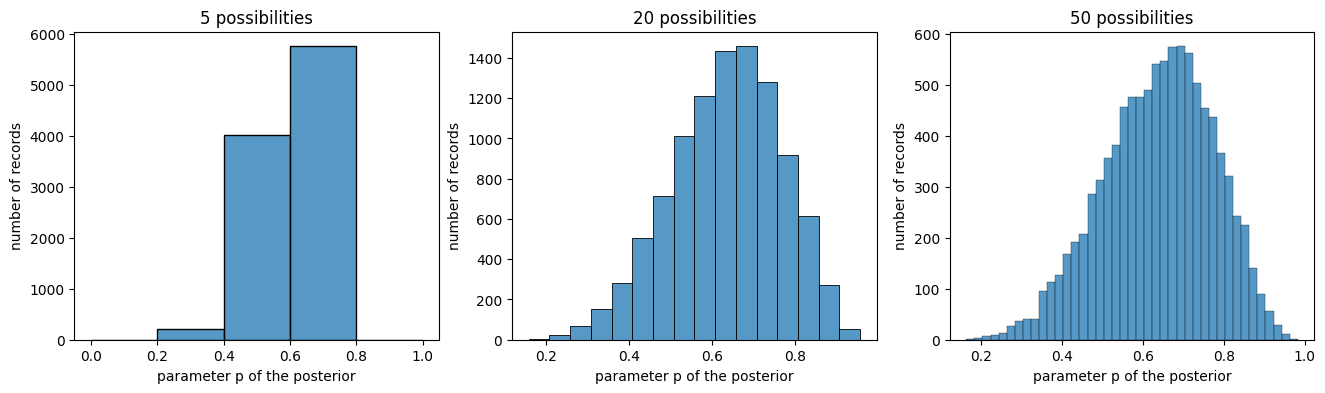

In [3]:
fig, axs = plt.subplots(ncols=3)
p_grid, posterior, samples = posterior_samples(9, 6, 5, 10000)
print(posterior, np.unique(samples["proportion"].values))
h = sns.histplot(data=samples, x='proportion', binwidth=1/5, binrange=[0,1], ax=axs[0])
h.set(xlabel='parameter p of the posterior', ylabel='number of records', title="5 possibilities")
p_grid, posterior, samples = posterior_samples(9, 6, 20, 10000)
h = sns.histplot(data=samples, x='proportion', binwidth=1/20, ax=axs[1])
h.set(xlabel='parameter p of the posterior', ylabel='number of records', title="20 possibilities")
p_grid, posterior, samples = posterior_samples(9, 6, 50, 10000)
h = sns.histplot(data=samples, x='proportion', binwidth=1/50, ax=axs[2])
h.set(xlabel='parameter p of the posterior', ylabel='number of records', title="50 possibilities")

fig.set_size_inches(16,4)

#### Infinite Possibilities
posterior probability of any side p $ \propto p^W (1-p)^L$

##### Beta Distribution
posterior probability of p $ = \frac{(W+L+1)!}{W!L!} p^W (1-p)^L$

### Code 3.1
Calculate the probability of being a vampire if the test returns positive

$$Pr(vampire | postive)$$

In [4]:
pr_pos_vamp = 0.95
pr_pos_mortal = 0.01
pr_vamp = 0.001
pr_pos = pr_pos_vamp * pr_vamp + pr_pos_mortal * (1 - pr_vamp)
pr_vamp_pos = pr_pos_vamp * pr_vamp / pr_pos
pr_vamp_pos

0.08683729433272395

That corresponds to an 8.7% chance that the suspect is actually a vampire.

Most people find this result counterintuitive. And it’s a very important result, because it mimics the structure of many realistic testing contexts, such as HIV and DNA testing, criminal profiling, and even statistical significance testing. Whenever the condition of interest is very rare, having a test that finds all the true cases is still no guarantee that a positive result carries much information at all. The reason is that most positive results are false positives, even when all the true positives are detected correctly.

### Why statistics can’t save bad science.

The vampirism example has the same logical structure as many different signal detection problems: (1) There is some binary state that is hidden from us; (2) we observe an imperfect cue of the hidden state; (3) we (should) use
Bayes’ theorem to logically deduce the impact of the cue on our uncertainty.

Scientific inference is often framed in similar terms: (1) An hypothesis is either true or false; (2) we use a statistical procedure and get an imperfect cue of the hypothesis’ falsity; (3) we (should) use Bayes’ theorem to logically deduce the impact of the cue on the status of the hypothesis. It’s the third
step that is hardly ever done. But let’s do it, for a toy example, so you can see how little statistical procedures—Bayesian or not—may do for us.

Suppose the probability of a positive finding, when an hypothesis is true, is Pr(sig|true) = 0.95. That’s the power of the test. Suppose that the probability of a positive finding, when an hypothesis is false, is Pr(sig|false) = 0.05. That’s the false-positive rate, like the 5% of conventional significance
testing. Finally, we have to state the base rate at which hypotheses are true. Suppose for example that 1 in every 100 hypotheses turns out to be true. Then Pr(true) = 0.01. No one knows this value, but the history of science suggests it’s small. 

Now use Bayes’ tocompute the posterior:

$$ Pr(true|pos) = \frac{Pr(pos|true) Pr(true)}{Pr(pos)} \\
= \frac{Pr(pos|true) Pr(true)}{Pr(pos|true) Pr(true) + Pr(pos|false) Pr(false)} $$

Plug in the appropriate values, and the answer is approximately Pr(true|pos) = 0.16. So a positive finding corresponds to a 16% chance that the hypothesis is true. This is the same low base-rate phenomenon that applies in medical (and vampire) testing. You can shrink the false-positive rate to 1% and get this posterior probability up to 0.5, only as good as a coin flip. The most important thing to do is to improve the base rate, Pr(true), and that requires thinking, not testing

### Code 3.2
Grid approximation refresher

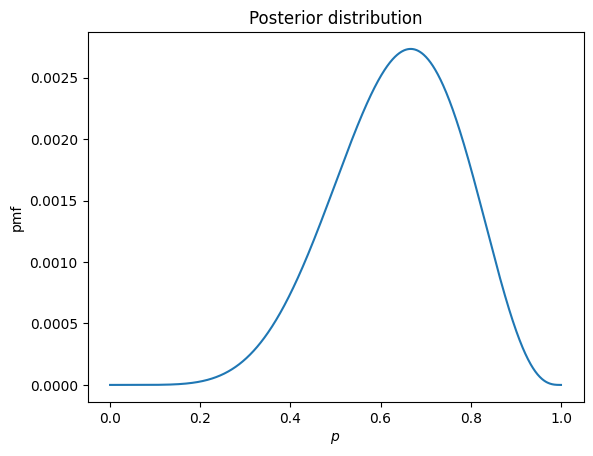

In [5]:
p_grid = np.linspace(0, 1, 1000)
prob_p = np.ones(1000)
prob_data = stats.binom(n=9, p=p_grid).pmf(6)
posterior = prob_data * prob_p
posterior /= sum(posterior)
plt.plot(p_grid, posterior)
plt.title("Posterior distribution")
plt.xlabel("$p$")
plt.ylabel("pmf")
plt.show()

### Code 3.3
Draw 10,000 samples from the above posterior

In [6]:
samples = np.random.choice(p_grid, p=posterior, size=10000)
samples

array([0.75575576, 0.65065065, 0.78978979, ..., 0.49049049, 0.68768769,
       0.60560561])

### Code 3.4
Scatter plot of the samples

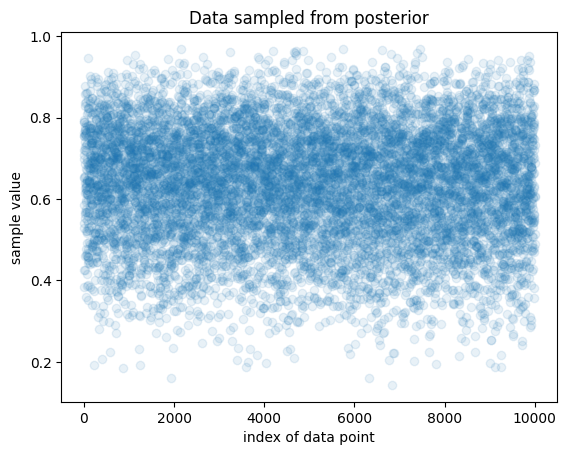

In [7]:
samples = samples[:10000]
plt.scatter(range(len(samples)), samples, alpha=0.1)
plt.title("Data sampled from posterior")
plt.xlabel("index of data point")
plt.ylabel("sample value")
plt.show()

### Code 3.5
Plot a kernel density estimate (KDE) of the distribution

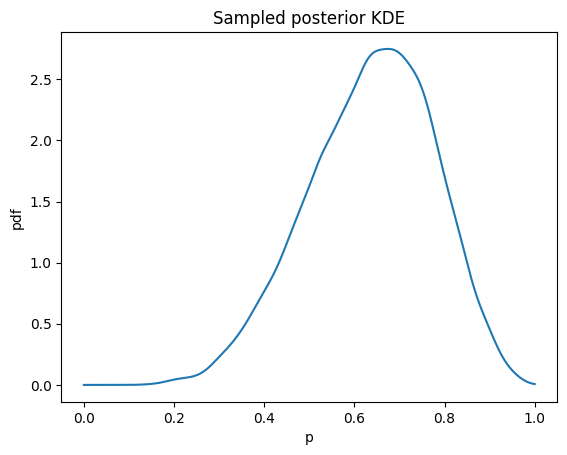

In [8]:
x = np.linspace(0, 1, 1000)
y = stats.gaussian_kde(samples, bw_method=0.15).pdf(x)
plt.plot(x, y)
plt.title("Sampled posterior KDE")
plt.xlabel("p")
plt.ylabel("pdf")
plt.show()

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,sample_number,proportion
0,0,0.755756
1,1,0.650651
2,2,0.789790
3,3,0.384384
4,4,0.426426


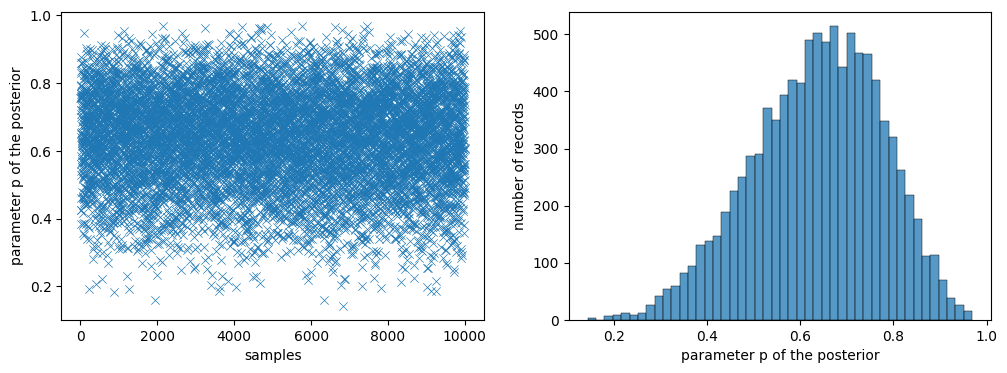

In [9]:
fig, axs = plt.subplots(ncols=2)
samples_df = pd.DataFrame(data={"sample_number": range(len(samples)), "proportion": samples})

s = sns.scatterplot(data=samples_df, x='sample_number', y='proportion', marker='x', ax=axs[0])
s.set(xlabel='samples', ylabel='parameter p of the posterior')
h = sns.histplot(data=samples_df, x='proportion', ax=axs[1])
h.set(xlabel='parameter p of the posterior', ylabel='number of records')
fig.set_size_inches(12,4)
samples_df.head()

# Sampling to Summarize

common questions include:
- How much posterior probability lies below some parameter value?
- How much posterior probability lies between two parameter values?
- Which parameter value marks the lower 5% of the posterior probability?
- Which range of parameter values contains 90% of the posterior probability?
- Which parameter value has highest posterior probability?

These simple questions can be usefully divided into questions about (1) intervals of defined boundaries, (2) questions about intervals of defined probability mass, and (3) questions about point estimates.


## Intervals of defined boundaries

### Code 3.6
Calculate the probability of $p < 0.5$ using the posterior from the grid approximation

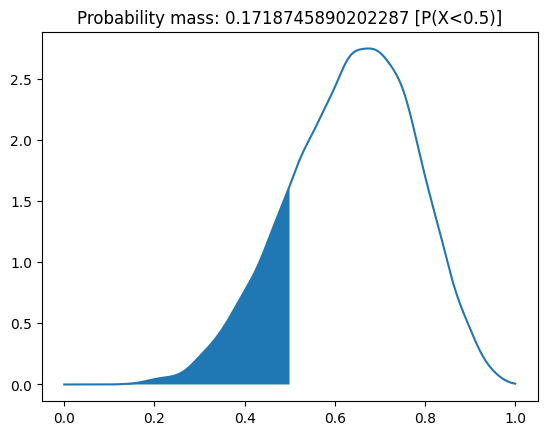

In [10]:
plt.plot(p_grid, y)
plt.fill_between(x[x<0.5], y[x<0.5], 0)
p = posterior[p_grid<0.5].sum()
plt.title(f"Probability mass: {p} [P(X<0.5)]")
plt.show()

### Code 3.7
Calculate the probability of $p < 0.5$ using the samples from the posterior

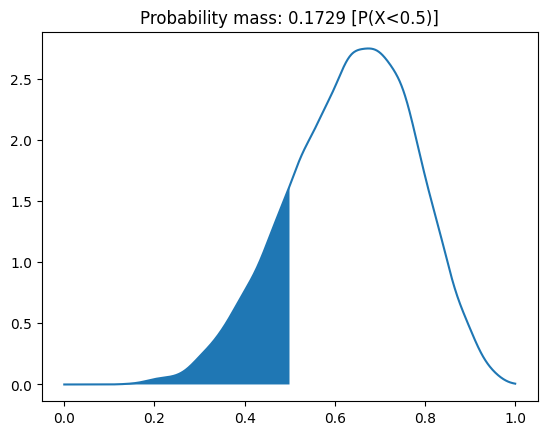

In [11]:
plt.plot(p_grid, y)
plt.fill_between(x[x<0.5], y[x<0.5], 0)
p = (samples < 0.5).sum()/len(samples)
plt.title(f"Probability mass: {p} [P(X<0.5)]")
plt.show()

### Code 3.8
Calculate the posterior probability of being between 0.5 and 0.75

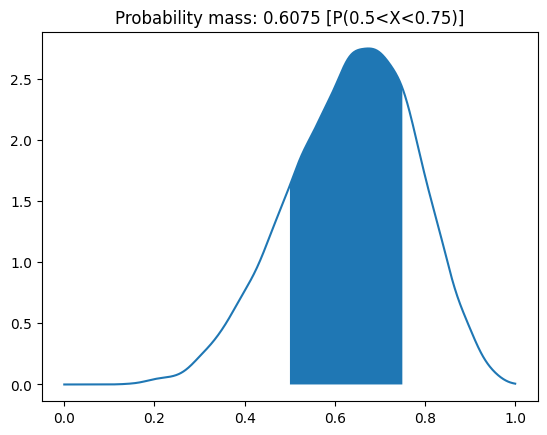

In [12]:
plt.plot(p_grid, y)
mask = (0.5<x) & (x<0.75)
plt.fill_between(x[mask], y[mask], 0)
p = ((0.5 < samples) & (samples < 0.75)).sum()/len(samples)
plt.title(f"Probability mass: {p} [P(0.5<X<0.75)]")
plt.show()

## Intervals of defined mass

### Code 3.9
Find the lower 80% quantile of the posterior using samples

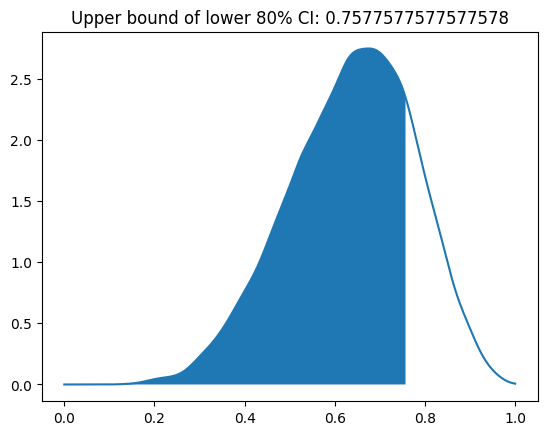

In [13]:
plt.plot(p_grid, y)
q = np.quantile(samples, 0.8)
mask = (x<q)
plt.fill_between(x[mask], y[mask], 0)
plt.title(f"Upper bound of lower 80% CI: {q}")
plt.show()

### Code 3.10
Find the 10 and 90th percentiles

percentile intervals (PI) assign equal probability mass to each tail.

In [14]:
q1, q2 = np.quantile(samples, [0.1, 0.9])
print(q1, q2)

0.44644644644644643 0.8088088088088088


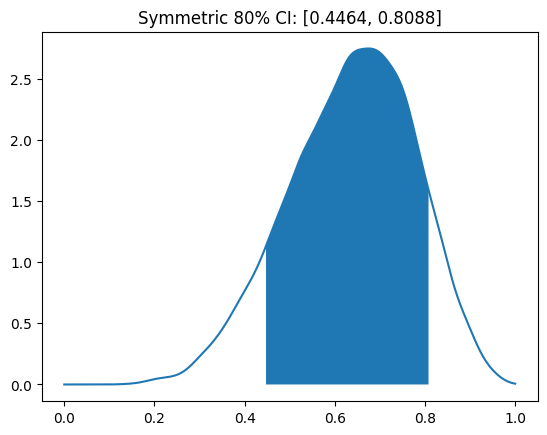

In [15]:
plt.plot(p_grid, y)
q1, q2 = np.quantile(samples, [0.1, 0.9])
mask = (q1<x) & (x<q2)
plt.fill_between(x[mask], y[mask], 0)
plt.title(f"Symmetric 80% CI: [{q1:.4f}, {q2:.4f}]")
plt.show()

### Code 3.11
Compute the posterior for the 3 successes in 3 trials distribution; this one is a bit more asymmetric

In [16]:
# Calculate posterior using grid approx
p_grid = np.linspace(0, 1, 1000)
prior = np.ones(len(p_grid))
likelihood = stats.binom(n=3, p=p_grid).pmf(3)
posterior = likelihood * prior
posterior /= posterior.sum()
# Sample from posterior
samples = np.random.choice(p_grid, size=10000, p=posterior)

### Code 3.12
Compute 50% symmetric credible interval

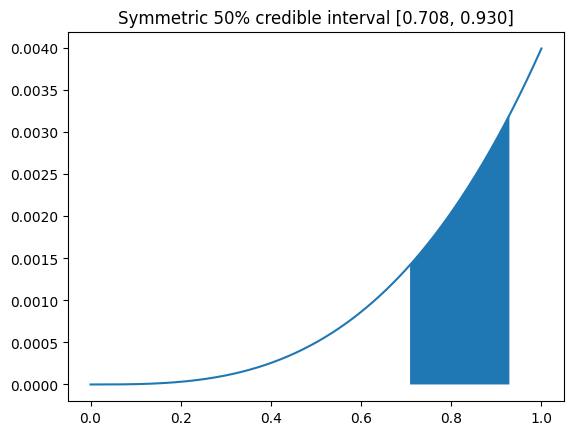

In [17]:
plt.plot(p_grid, posterior)
q1, q2 = np.quantile(samples, [0.25, 0.75])
mask = (q1<p_grid) & (p_grid<q2)
x = p_grid[mask]
y = posterior[mask]
plt.fill_between(x, y, 0)
plt.title(f"Symmetric 50% credible interval [{q1:.3f}, {q2:.3f}]")
plt.show()

Above plot misses high density region. 

The highest posterior density interval (HPDI) is the narrowest interval containing the specified probability mass. If you think about it, there must be an infinite number of posterior intervals with the same mass. But if you want an interval that best represents the parameter values most consistent with the data, then you want the densest of these intervals. That’s what the HPDI is.

### Code 3.13
Compute the 50% HPDI (Highest Posterior Density Interval), which is the densest interval containing the given probability mass

In [18]:
# This looks really useful, I'm going to save it for later
def HPDI(samples, prob):
    samples = sorted(samples)
    N = len(samples)
    W = int(round(N*prob))
    min_interval = float('inf')
    bounds = [0, W]
    for i in range(N-W):
        interval = samples[i+W] - samples[i]
        if interval < min_interval:
            min_interval = interval
            bounds = [i, i+W]
    return samples[bounds[0]], samples[bounds[1]]

In [19]:
HPDI(samples, 0.5)

(0.8408408408408409, 1.0)

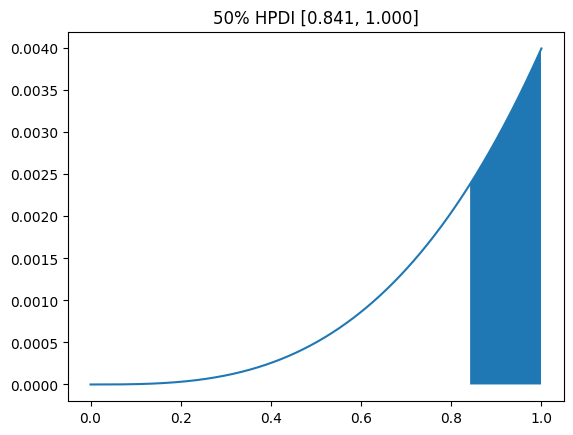

In [20]:
plt.plot(p_grid, posterior)
q1, q2 = HPDI(samples, 0.5)
mask = (q1<p_grid) & (p_grid<q2)
x = p_grid[mask]
y = posterior[mask]
plt.fill_between(x, y, 0)
plt.title(f"50% HPDI [{q1:.3f}, {q2:.3f}]")
plt.show()

So the HPDI has some advantages over the PI. But in most cases, these two types of
interval are very similar. They only look so different in this case because the posterior distribution is highly skewed.

The HPDI also has some disadvantages. HPDI is more computationally intensive than PI and suffers from greater simulation variance, which is a fancy way of saying that it is sensitive to how many samples you draw from the posterior.

Intervals of the distribution are just helpful for summarizing it. If choice of interval leads to different inferences, then you’d be better off just plotting the entire posterior distribution.

## Point Estimates

### Code 3.14
Compute the MAP estimate for the above example using the grid posterior

In [21]:
p_grid[np.argmax(posterior)]

1.0

### Code 3.15
Get a MAP estimate from the samples

In [22]:
counts, bins = np.histogram(samples, bins=100)
i = np.argmax(counts)
(bins[i] + bins[i+1])/2

0.9675225225225225

### Code 3.16
What are the mean/median of the samples?

In [23]:
print(f"mean: {samples.mean()}")
print(f"median: {np.median(samples)}")

mean: 0.8004125125125126
median: 0.8408408408408409


### Code 3.17
Compute the expected loss from guessing the point estimate $\hat{p}$, where $L(\hat{p}) = |\hat{p} - p|$ ($p$ is the "true" value), for the value $\hat{p} = 0.5$

In [24]:
sum(posterior * abs(0.5 - p_grid))

0.3128751874998122

### Code 3.18/3.19
Calculate the loss curve over all values of $\hat{p}$ and find the one that minimizes $L$

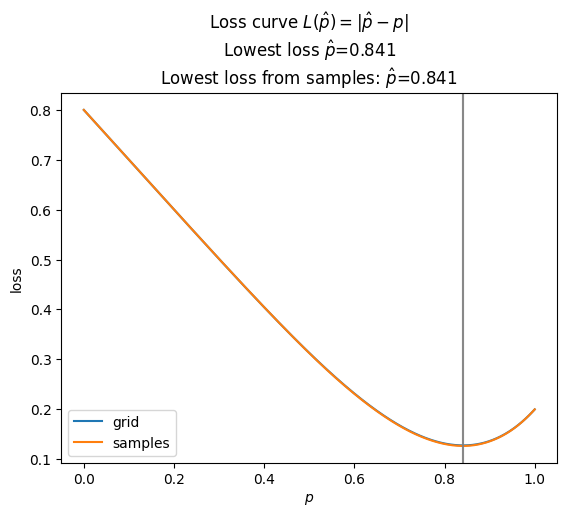

In [25]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid] # Using grid estimate posterior
loss_sampled = [abs(p - samples).mean() for p in p_grid] # Using posterior samples
min_loss = p_grid[np.argmin(loss)]
min_loss_sampled = p_grid[np.argmin(loss_sampled)]
plt.plot(p_grid, loss, label="grid")
plt.plot(p_grid, loss_sampled, label="samples")
plt.axvline(min_loss, color="grey", alpha=0.75)
plt.axvline(min_loss_sampled, color="grey", alpha=0.75)
plt.title(
    "Loss curve $L(\hat{p}) = |\hat{p} - p|$\nLowest loss $\hat{p}$="
    f"{min_loss:.3f}\n""Lowest loss from samples: $\hat{p}$="
    f"{min_loss_sampled:.3f}"
)
plt.xlabel("$p$")
plt.ylabel("loss")
plt.legend()
plt.show()

### Code 3.20
Compute the probability of 0, 1, 2 successes out of 2 trials with $p=0.7$

In [26]:
stats.binom(n=2, p=0.7).pmf([0, 1, 2])

array([0.09, 0.42, 0.49])

### Code 3.21/3.22
Sample from the above distribution

In [27]:
stats.binom(n=2, p=0.7).rvs(10)

array([2, 2, 2, 1, 1, 1, 2, 2, 1, 2])

### Code 3.23
Sample 100,000 times to verify that it is the sample proportion as expected by the pmf

In [28]:
W = stats.binom(n=2, p=0.7).rvs(100_000)
vals, counts = np.unique(W, return_counts=True)
W = np.stack([vals, counts/len(W)])
print(W)

[[0.      1.      2.     ]
 [0.09058 0.42061 0.48881]]


### Code 3.24
Simulate 9 tosses of the globe, like before

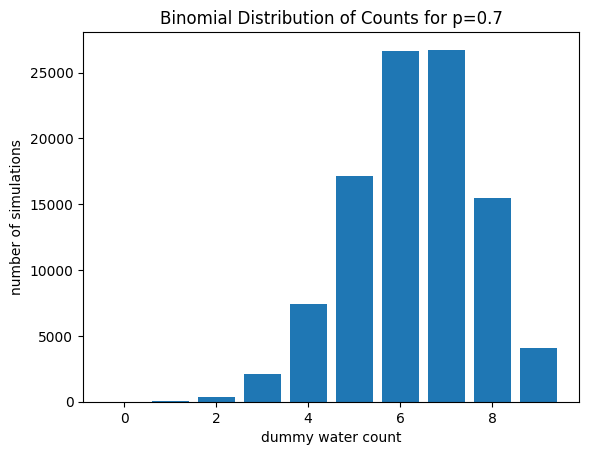

In [29]:
W = stats.binom(n=9, p=0.7).rvs(100_000)
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("dummy water count")
plt.ylabel("number of simulations")
plt.title("Binomial Distribution of Counts for p=0.7")
plt.show()

### Code 3.25/3.26
Calculate the posterior predictive distribution for the data (W counts) using the samples we drew from earlier

[8 5 5 ... 5 5 8]


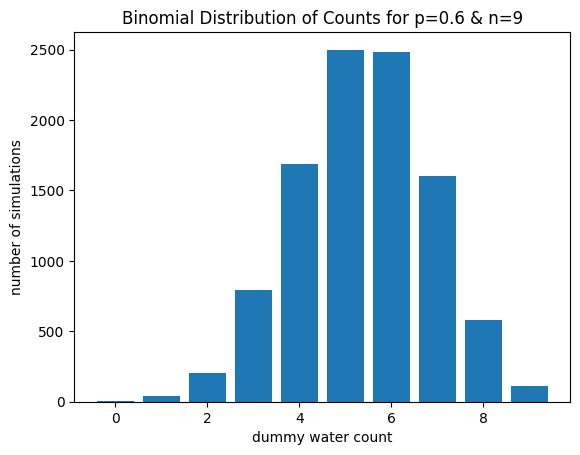

In [30]:
# 10k samples from just the value p=0.6 creates an overconfident
# data prediction
W = stats.binom(n=9, p=0.6).rvs(10_000) 
print(W)
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("dummy water count")
plt.ylabel("number of simulations")
plt.title("Binomial Distribution of Counts for p=0.6 & n=9")
plt.show()

### Posterior predictive distribution 
We’d like to propagate the parameter uncertainty—carry it forward—as we evaluate the implied predictions.  For each possible value of the parameter p, there is an implied distribution of outcomes. So if you were to compute the sampling distribution of outcomes at each value of p, then you could average all of these prediction distributions together, using the posterior probabilities of each value of p, to get a posterior predictive distribution.

For each sampled value, a random binomial observation is generated. Since the sampled values appear in proportion to their posterior probabilities, the resulting simulated observations are averaged over the posterior.

The resulting distribution is for predictions, but it incorporates all of the uncertainty embodied in the posterior distribution for the parameter p. As a result, it is honest. While the model does a good job of predicting the data—the most likely observation is indeed the observed data—predictions are still quite spread out. If instead you were to use only a single parameter value to compute implied predictions, say the most probable value at the peak of posterior distribution, you’d produce an overconfident distribution of predictions, narrower than the posterior predictive distribution.

The usual effect of this overconfidence will be to lead you to believe that the model is more consistent with the data than it really is— the predictions will cluster around the observations more tightly. This illusion arises from tossing away uncertainty about the parameters.

In [31]:
# Distribution at fixed p=0.6
W = stats.binom(n=9, p=0.6).rvs(10_000) 

# Posterior Predictive Distribution
samples = stats.beta(6+1, 3+1).rvs(10_000) # sample 10k times from analytic posterior (W=6, L=3)
W = stats.binom(n=9, p=samples).rvs() # sample from posterior predictive

(10000,) (10000,)


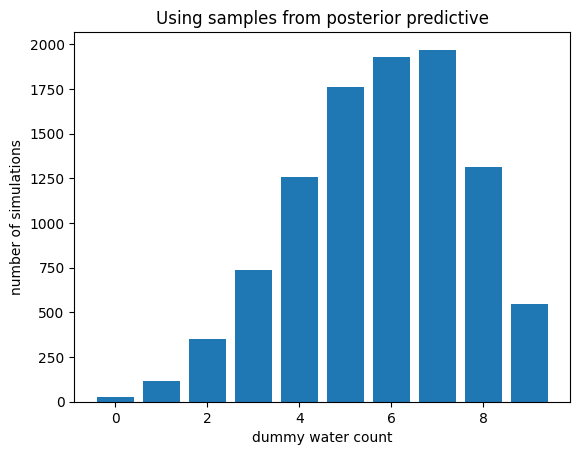

In [32]:
# If you use the samples from the posterior for $p$, it 
# preserves the uncertainty much better
samples = stats.beta(6+1, 3+1).rvs(10_000) # sample 10k times from analytic posterior (W=6, L=3)
W = stats.binom(n=9, p=samples).rvs() # sample from posterior predictive
print(samples.shape, W.shape)
vals, counts = np.unique(W, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("dummy water count")
plt.ylabel("number of simulations")
plt.title("Using samples from posterior predictive")
plt.show()

### Code 3.26.1
Create plots looking at the longest consecutive run length, and number of switches for the data generated from the posterior predictive distribution

In [33]:
# Generate the actual success/failures rather than counts from the PPD
W = stats.bernoulli.rvs(samples, size=[9, len(samples)]).T
# count longest consecutive sequence
max_len = np.ones(len(samples))
cur_len = np.ones(len(samples))
num_switches = np.zeros(len(samples))
for i in range(9-1):
    cons = (W[:,i] == W[:,i+1])
    cur_len[cons] += 1
    cur_len[~cons] = 1
    max_len = np.maximum(max_len, cur_len)
    num_switches += ~cons

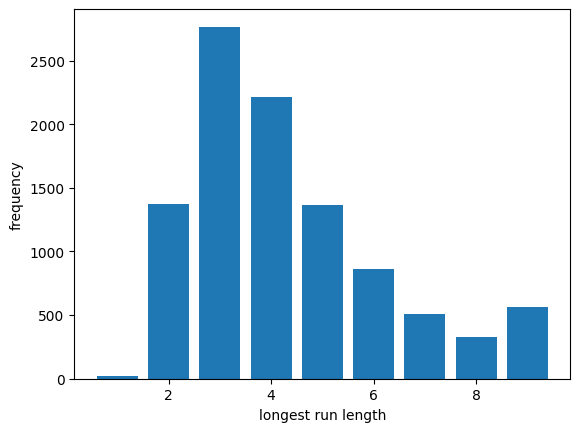

In [34]:
vals, counts = np.unique(max_len, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("longest run length")
plt.ylabel("frequency")
plt.show()

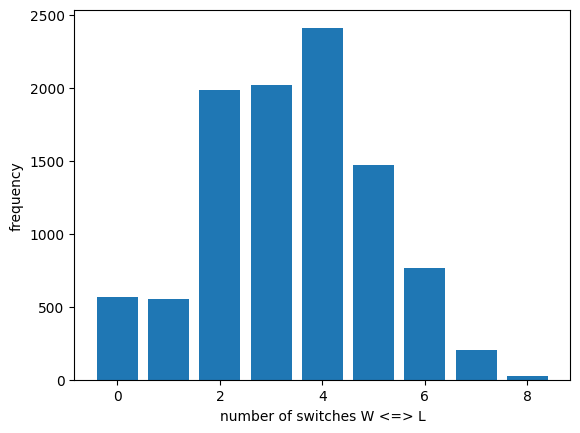

In [35]:
vals, counts = np.unique(num_switches, return_counts=True)
plt.bar(vals, counts)
plt.xlabel("number of switches W <=> L")
plt.ylabel("frequency")
plt.show()

## Practice

### 3E1-3E7 (including Code 3.27)
Generate some samples for the globe-tossing model

In [36]:
p_grid = np.linspace(0, 1, 1000)
prior = np.ones(len(p_grid))
likelihood = stats.binom(n=9, p=p_grid).pmf(6)
posterior = likelihood * prior
posterior /= posterior.sum()
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=10_000)

Now answer some questions about the distribution using the samples

In [37]:
# 3E1: How much posterior probability lies below p=0.2?


In [38]:
# 3E2: How much posterior probability lies above p=0.8?


In [39]:
# 3E3: How much posterior probability lies between p=0.2 and p=0.8?


In [40]:
# 3E4: 20% of the posterior probability lies below which value of p?


In [41]:
# 3E5: 20% of the posterior probability lies above which value of p?


In [42]:
# 3E6: Which values of p contain the narrowest interval equal to
# 66% of the posterior probability?


### 3M1
Suppose the globe-tossinge data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

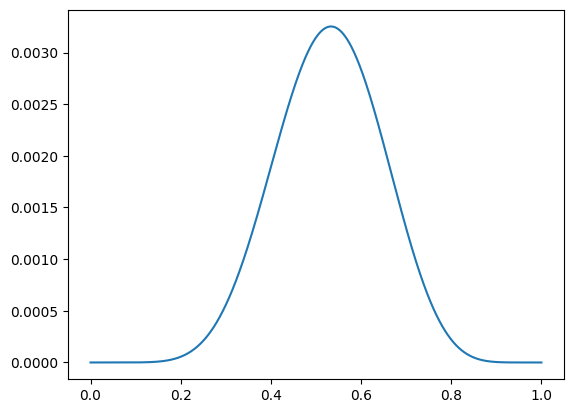

In [43]:
p_grid = np.linspace(0, 1, 1000)
prior = np.ones(len(p_grid))
likelihood = stats.binom(n=15, p=p_grid).pmf(8)
posterior = likelihood * prior
posterior /= posterior.sum()
plt.plot(p_grid, posterior)
plt.show()

### 3M2
Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for $p$.

### 3M3
Constuct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in $p$. What is the probability of observing 8 water in 15 tosses?

### 3M4
Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses